# Library Setup

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

# Data Import and Graph Creation

In [18]:
edges_df = pd.read_csv('../data/gephi-edge-list.csv')
nodes_df = pd.read_csv('../data/gephi-node-list.csv')

# General NFL Graph
G = nx.Graph() 

# nodes_df = nodes_df[nodes_df["fantasy_points"] >= 100]

# Add nodes
for _, row in nodes_df.iterrows():
    node_id = row['ID']
    attributes = row.drop('ID').to_dict()
    G.add_node(node_id, **attributes)

# Add the edges
for _, row in edges_df.iterrows():
    source = row['Source']
    target = row['Target']
    edge_attrs = row.drop(['Source', 'Target']).to_dict()
    G.add_edge(source, target, **edge_attrs)    

# Teammates from the same college conference graph
# Map player ID to college conference
player_to_college_conference = nodes_df.set_index('ID')['college_conference'].to_dict()

# Filter edges where both players attended the same college
same_college_conference_edges = []
for u, v, d in G.edges(data=True):
    college_conference_u = player_to_college_conference.get(u)
    college_conference_v = player_to_college_conference.get(v)
    
    if college_conference_u and college_conference_v and college_conference_u == college_conference_v:
        same_college_conference_edges.append((u, v, d['Weight']))
        
GCC = nx.Graph()
GCC.add_weighted_edges_from(same_college_conference_edges)
    
# Teammates from the same college graph
# Map player ID to college
player_to_college = nodes_df.set_index('ID')['college_name'].to_dict()

# Filter edges where both players attended the same college
same_college_edges = []
for u, v, d in G.edges(data=True):
    college_u = player_to_college.get(u)
    college_v = player_to_college.get(v)
    
    if college_u and college_v and college_u == college_v:
        same_college_edges.append((u, v, d['Weight']))
        
GC = nx.Graph()
GC.add_weighted_edges_from(same_college_edges)
    

# Computing Average and Weighted Degrees


In [19]:
# Full network
full_degrees = [deg for _, deg in G.degree(weight='weight')]
avg_full = sum(full_degrees) / len(full_degrees)

# Same-college subgraph
college_degrees = [deg for _, deg in GC.degree(weight='weight')]
avg_college = sum(college_degrees) / len(college_degrees)

print(f"Average weighted degree (full network): {avg_full:.2f}")
print(f"Average weighted degree (same-college teammates): {avg_college:.2f}")

Average weighted degree (full network): 43.59
Average weighted degree (same-college teammates): 191.49


# Degree Plot

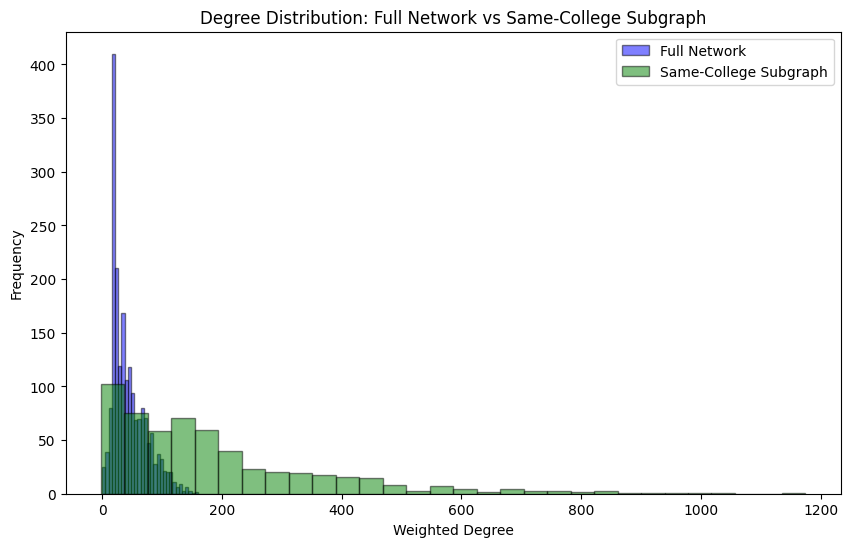

In [20]:
# Plot degree distributions
plt.figure(figsize=(10, 6))
plt.hist(full_degrees, bins=30, alpha=0.5, label="Full Network", color='blue', edgecolor='black')
plt.hist(college_degrees, bins=30, alpha=0.5, label="Same-College Subgraph", color='green', edgecolor='black')
plt.xlabel('Weighted Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution: Full Network vs Same-College Subgraph')
plt.legend()
plt.show()

# Statistical Significance

In [30]:
# Observed metric from your actual network
obs_avg = avg_college
print(f'College Weighted Degree Average: {obs_avg:.2f}')
print("Observed avg weighted degree in same-college subgraph: {:.3f}".format(obs_avg))

# Load an ensemble of ER graphs; only need the avg_weighted_degree_ER here
with open('null_model_ensemble_data.pkl', 'rb') as f:
    loaded_ensemble_data = pickle.load(f)
avg_weighted_degree_ER = loaded_ensemble_data['avg_weighted_degree_ER']

mean_ER = np.mean(avg_weighted_degree_ER)
std_ER = np.std(avg_weighted_degree_ER)

print("ER null model mean: {:.3f}".format(mean_ER))
print("ER null model std: {:.3f}".format(std_ER))


College Weighted Degree Average: 191.49
Observed avg weighted degree in same-college subgraph: 191.490
ER null model mean: 4433.034
ER null model std: 27.469


In [31]:
p_value = np.mean([m >= obs_avg for m in avg_weighted_degree_ER])
print("p-value:", p_value)

p-value: 1.0


# Visualizing Comparison to Null Model

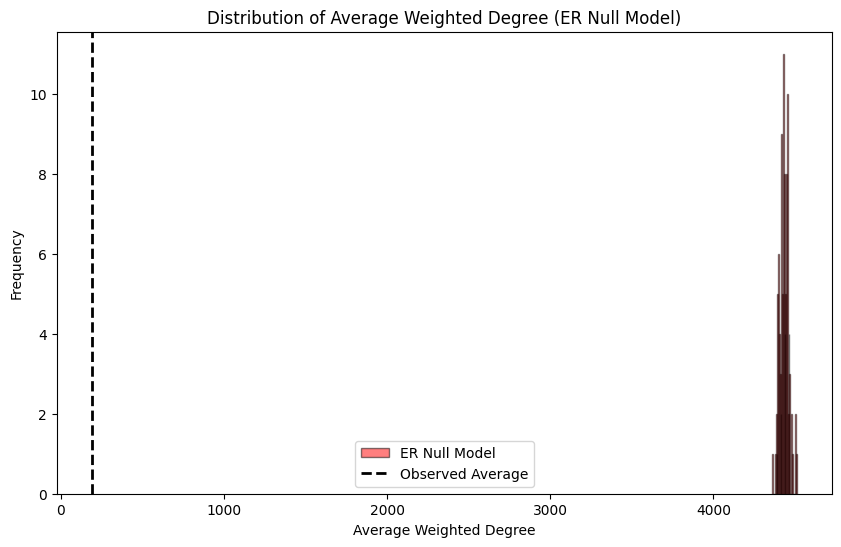

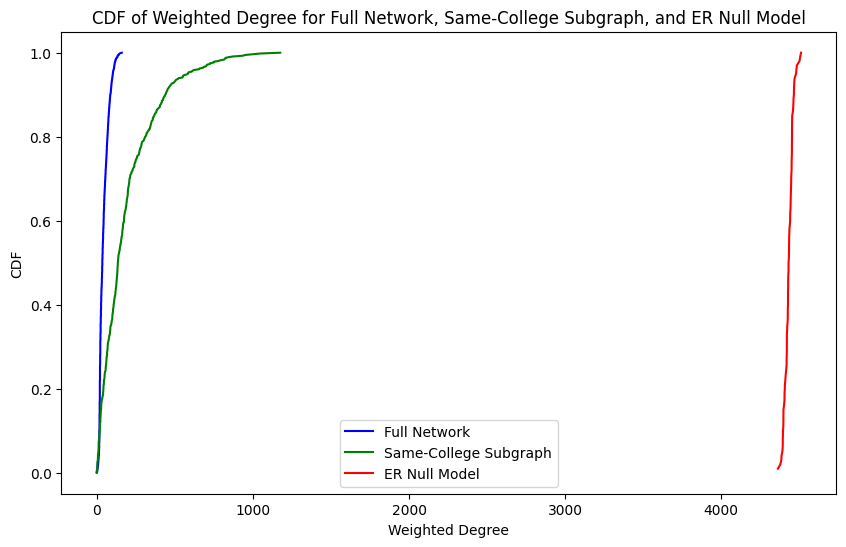

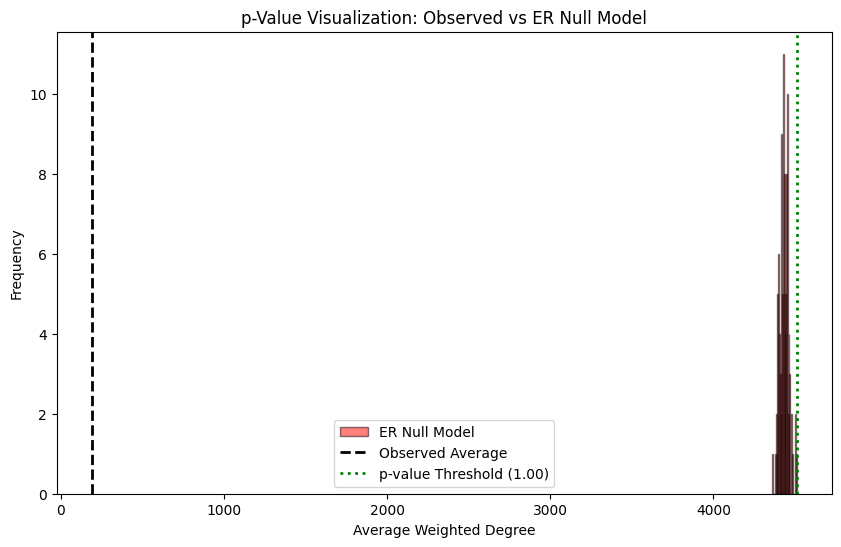

In [32]:
# Function to plot CDF
def plot_cdf(data, label, color):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    plt.plot(sorted_data, yvals, label=label, color=color)

plt.figure(figsize=(10, 6))
plt.hist(avg_weighted_degree_ER, bins=30, alpha=0.5, label="ER Null Model", color='red', edgecolor='black')
plt.axvline(obs_avg, color='black', linestyle='dashed', linewidth=2, label="Observed Average")
plt.xlabel('Average Weighted Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Average Weighted Degree (ER Null Model)')
plt.legend()
plt.show()

# Plot CDFs for the full network, same-college subgraph, and ER model
plt.figure(figsize=(10, 6))
plot_cdf(full_degrees, 'Full Network', 'blue')
plot_cdf(college_degrees, 'Same-College Subgraph', 'green')
plot_cdf(avg_weighted_degree_ER, 'ER Null Model', 'red')
plt.xlabel('Weighted Degree')
plt.ylabel('CDF')
plt.title('CDF of Weighted Degree for Full Network, Same-College Subgraph, and ER Null Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(avg_weighted_degree_ER, bins=30, alpha=0.5, label="ER Null Model", color='red', edgecolor='black')
plt.axvline(obs_avg, color='black', linestyle='dashed', linewidth=2, label="Observed Average")
plt.axvline(np.percentile(avg_weighted_degree_ER, 100 * p_value), color='green', linestyle='dotted', linewidth=2, label=f"p-value Threshold ({p_value:.2f})")
plt.xlabel('Average Weighted Degree')
plt.ylabel('Frequency')
plt.title('p-Value Visualization: Observed vs ER Null Model')
plt.legend()
plt.show()

# Additional Null Model (Depricated)

In [22]:
import random

num_trials = 1000
num_edges = GC.number_of_edges()
avg_random_degrees = []

nodes = list(G.nodes())

for _ in range(1000):
    random_edges = set()
    while len(random_edges) < num_edges:
        u, v = random.sample(nodes, 2)
        if G.has_edge(u, v):
            random_edges.add((u, v))
    
    G_random = nx.Graph()
    for u, v in random_edges:
        weight = G[u][v]['Weight']
        G_random.add_edge(u, v, weight=weight)
    
    degrees = [deg for _, deg in G_random.degree(weight='Weight')]
    avg_random_degrees.append(sum(degrees) / len(degrees))

# Actual value
actual_avg = sum([deg for _, deg in GC.degree(weight='Weight')]) / len(GC)

# Proportion of random averages >= actual
p_value = sum(x >= actual_avg for x in avg_random_degrees) / num_trials
print(f"Empirical p-value: {p_value:.4f}")

Empirical p-value: 0.0000
